## Import neccessary packages

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#for plots
import scikitplot as skplt

#for time calc
from time import time

#for model evaluations
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#for EDA
import pandas_profiling
from imblearn.under_sampling import RandomUnderSampler

#for Model metrics
from sklearn.metrics import classification_report

### Read Data and store as Pandas DataFrame

In [50]:
df = pd.read_csv("raw_data.csv")

### Exploratory Data Analysis
- Using Pandas Profiler and other traditional ways

In [51]:
df.head()

,Unnamed: 0,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime
0,1,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,View,Facebook,300x600,Carter's,Pink,0.171601
1,2,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,View,Facebook,300x250,Burberry,Red,4.303945
2,3,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,View,Facebook,728x90,Disney,Yellow,0.868106
3,4,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,View,Facebook,320x50,Carter's,Yellow,0.802647
4,5,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,View,instagram.com,300x250,Gap,Gold,0.627148


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
Unnamed: 0         1000000 non-null int64
ID                 1000000 non-null object
ActionTime         1000000 non-null int64
Action             1000000 non-null object
Website            1000000 non-null object
BannerSize         1000000 non-null object
Brand              1000000 non-null object
colour             1000000 non-null object
InteractionTime    999992 non-null float64
dtypes: float64(1), int64(2), object(6)
memory usage: 68.7+ MB


### Drop columns that are not important and cause data leakages

In [53]:
#drop ID columns
df.drop(columns = 'Unnamed: 0',inplace=True)

#convert unix time format into datetime
df['ActionTime'] = pd.to_datetime(df['ActionTime'],unit='us')
#add a day feature
df['day'] = df['ActionTime'].dt.weekday
#add a timebin
df['timebin'] = pd.cut(df['ActionTime'].dt.hour,[0,7,10,12,14,16,22,24],include_lowest=True)


#### - Sort columns by ID and other required columns as below

In [34]:
df = df.sort_values(by=['ID','Website','Brand','ActionTime','Action']).reset_index().drop(columns='index')

In [35]:
df['Action'].value_counts(normalize = True)

View     0.999756
Click    0.000244
Name: Action, dtype: float64

### Train and test split
- Since lable is highly imbalanced, we may need create new feature and probably need to up / downsamplig based on any of the base model performance. 
- Random split by train_test_split may split transactionational history between train / Test, try spliting by ID or order and split at required ratio

In [45]:
#Train : Test Split at 66.66: 33.33 
dfx = df[:666666]
dft = df[666666:]
dfx.shape
dft.shape

(666666, 10)

(333334, 10)

#### Verify the lable split in train and test split

In [37]:
dfx.Action.value_counts(normalize=True)
dft.Action.value_counts(normalize=True)

View     0.999763
Click    0.000237
Name: Action, dtype: float64

View     0.999742
Click    0.000258
Name: Action, dtype: float64

In [38]:
dfx.columns

Index(['ID', 'ActionTime', 'Action', 'Website', 'BannerSize', 'Brand',
       'colour', 'InteractionTime', 'day', 'timebin'],
      dtype='object')

### Process Train Set (feature engineering)

In [39]:
dfx['proxy'] = dfx['Action'].map({'View': 1, 'Click' : 0})

dfx['InteractionTime'] = dfx['InteractionTime'].fillna(dfx['InteractionTime'].mean())

dfx['sitecounter'] = dfx.groupby(by=['ID','Website'],as_index=False)['proxy'].transform('cumsum')
dfx['brandcounter'] = dfx.groupby(by=['ID','Brand'],as_index=False)['proxy'].transform('cumsum')
dfx['colourcounter'] = dfx.groupby(by=['ID','colour'],as_index=False)['proxy'].transform('cumsum')

dfx['Action'] = dfx['Action'].map({'View': 0, 'Click' : 1})
dfx.drop(columns=['ID','ActionTime','proxy'], inplace=True)
Xtrain = pd.get_dummies(dfx.drop(columns = ['Action']), drop_first=True)
ytrain = dfx['Action']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

### Process Test Set (feature engineering)

In [40]:
dft['proxy'] = dft['Action'].map({'View': 1, 'Click' : 0})
dft['InteractionTime'] = dft['InteractionTime'].fillna(dft['InteractionTime'].mean())
dft['sitecounter'] = dft.groupby(by=['ID','Website'],as_index=False)['proxy'].transform('cumsum')
dft['brandcounter'] = dft.groupby(by=['ID','Brand'],as_index=False)['proxy'].transform('cumsum')
dft['colourcounter'] = dft.groupby(by=['ID','colour'],as_index=False)['proxy'].transform('cumsum')
dft['Action'] = dft['Action'].map({'View': 0, 'Click' : 1})
dft.drop(columns=['ID','ActionTime','proxy'], inplace=True)
Xtrain = pd.get_dummies(dft.drop(columns = ['Action']), drop_first=True)
ytrain = dft['Action']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

## Random Forest Model

In [41]:
rf = RandomForestClassifier(random_state = 42, class_weight = 'balanced')

rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test,y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    333248
           1       1.00      0.69      0.81        86

    accuracy                           1.00    333334
   macro avg       1.00      0.84      0.91    333334
weighted avg       1.00      1.00      1.00    333334



### Random Forest Feature Importance

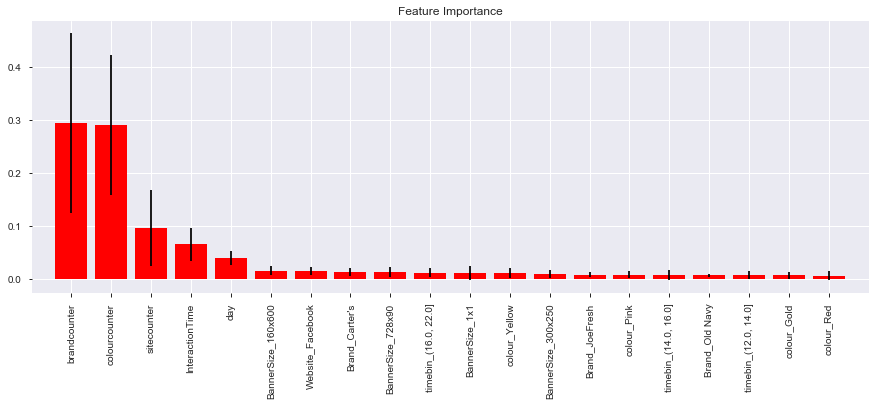

In [42]:
skplt.estimators.plot_feature_importances(rf, feature_names=X_test.columns,x_tick_rotation = 90,figsize = (15,5))

## Decision Tree Classifier

In [43]:
dt = DecisionTreeClassifier(random_state = 42, class_weight = 'balanced')

dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)

print(classification_report(y_test,y_pred))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    333248
           1       0.82      0.74      0.78        86

    accuracy                           1.00    333334
   macro avg       0.91      0.87      0.89    333334
weighted avg       1.00      1.00      1.00    333334



### Decision Tree Feature Importance

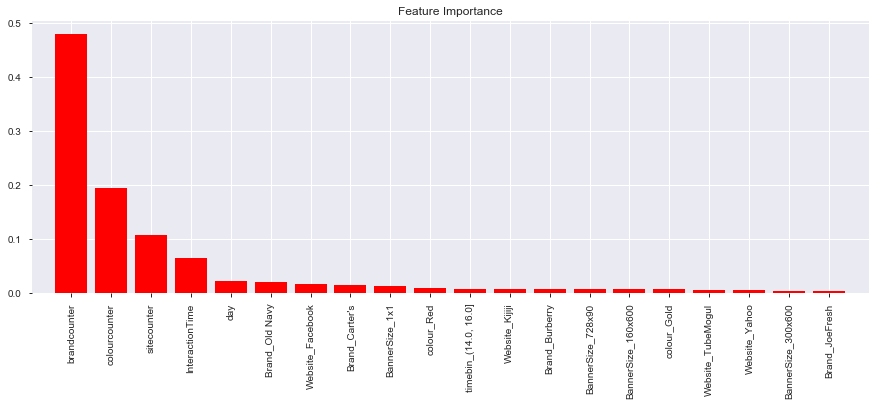

In [44]:
skplt.estimators.plot_feature_importances(dt, feature_names=X_test.columns,x_tick_rotation = 90,figsize = (15,5))